## Simsiam Pretrained ViT Base Backbone 

---

For classifying lenses from non-lenses, self-supervised learning (SSL), particularly with the transformer backbones could potentially outperform traditional supervised methods with abundant unlabelled dataset. The learned representations are then evaluated on the downstream task to classify lens and non-lens images. <br>
The train dataset contains 2333 lens images and 1530 non-lens images. The validation dataset contains 259 lens images and 170 non-lens images. The test dataset contains 458 lens images and 300 non-lens images. Each image has 3 channels, g, r and i, corresponding to green, red and infrared filters respectively. The images are center cropped to 32 × 32 pixel as this empirically resulted in better downstream prediction accuracy. <br>
To understand how well SSL works with different fractions of labelled and unlabelled data, the model is pre-trained through self supervision on the entire train data and then finetuned on the labelled fraction of the train data and compared with supervised baseline trained only on that labeled fraction. This simulates the real world scenario where only a fraction of dataset may have associated labels. <br>
The following table summarizes the results on the held out test dataset.

| # labelled data for <br> training/fine-tuning | Training | Accuracy | AUC |
|:---:|:----------:|:----------:|:----------:|
|300|Supervised | 90.7652% | 0.9534 |
||Simsiam | 90.3694% | 0.9539 |
|600|Supervised | 92.6121% | 0.9579 |
||Simsiam | 92.0844% | 0.9589 |
|1200|Supervised | 93.4037% | 0.9678 |
||Simsiam | 93.5356% | 0.9817 |
|3863 |Supervised | 94.9868% | 0.9843 |
||Simsiam | 94.8549% | 0.9832 |

ROC Curves for the SSL and supervised models are plotted below

![](../assets/auc_supervised_simsiam_ssl_vit_base.png)

---

In [1]:
import sys
sys.path.append("/kaggle/input/deeplense-git/DeepLense_SSL_from_real_dataset_Sreehari_Iyer")
sys.path.append("/kaggle/input/deeplense-git/DeepLense_SSL_from_real_dataset_Sreehari_Iyer/selfsupervised")
!pip install GPUtil

  Preparing metadata (setup.py) ... - \ done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=e86a166bd452ad7255b65de5b66df6eec130987745121f09a2f46c39c932c947
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.transforms as Transforms
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn import metrics
import copy
import pickle
from utils import set_seed
from utils.eval import train
from models.backbone import Backbone
from augmentations.loader import npy_loader
from augmentations import ImageDataset
from models.classifier import Classifier
from utils.eval import test_
import matplotlib.pyplot as plt
set_seed(12)

In [3]:
def get_datasets(num_labelled_points):
    set_seed(12)

    eval_transforms = Transforms.Compose([
                    # Transforms.ToTensor(), # npy loader returns torch.Tensor
                    Transforms.CenterCrop(32),
                    Transforms.Normalize(mean = [0.19948305189609528, 0.6667526960372925, 1.2940289974212646],\
                                     std = [0.2700458765029907, 0.9860594868659973, 2.1648175716400146]),
                ])

    #--------------------------------------------------------------------------------------------------------

    train_test_indices = "/kaggle/input/reallenses-traintestindices/indices.pkl"
    data_path = "/kaggle/input/reallensdataset/real_lenses_dataset"
    
    train_indices_path = None
    indices = None
    with open(train_test_indices, "rb") as f:
        indices = pickle.load(f)
    train_indices = None
    
    if num_labelled_points == 300:
        train_indices_path = "/kaggle/input/reallenses-traintestindices/train_indices_300.pkl"
        with open(train_indices_path, "rb") as f:
            train_indices = pickle.load(f)
    elif num_labelled_points == 600:
        train_indices_path = "/kaggle/input/reallenses-traintestindices/train_indices_600.pkl"
        with open(train_indices_path, "rb") as f:
            train_indices = pickle.load(f)
    elif num_labelled_points == 1200:
        train_indices_path = "/kaggle/input/reallenses-traintestindices/train_indices_1200.pkl"
        with open(train_indices_path, "rb") as f:
            train_indices = pickle.load(f)
    elif num_labelled_points is None:
        train_indices_path = "/kaggle/input/reallenses-traintestindices/indices.pkl"
        with open(train_indices_path, "rb") as f:
            train_indices = pickle.load(f)
        train_indices = train_indices["train"]

    # train images and labels
    train_paths = [os.path.join(data_path, *["lenses", img]) for img in np.array(train_indices["lenses"])] +\
                    [os.path.join(data_path, *["nonlenses", img]) for img in np.array(train_indices["nonlenses"])]
    train_labels = [0]*len(train_indices["lenses"]) + [1]*len(train_indices["nonlenses"])

    # validation images and labels
    val_paths = [os.path.join(data_path, *["lenses", img]) for img in np.array(indices["val"]["lenses"])] +\
                    [os.path.join(data_path, *["nonlenses", img]) for img in np.array(indices["val"]["nonlenses"])]
    val_labels = [0]*len(indices["val"]["lenses"]) + [1]*len(indices["val"]["nonlenses"])

    # test images and labels
    test_paths = [os.path.join(data_path, *["lenses", img]) for img in np.array(indices["test"]["lenses"])] +\
                    [os.path.join(data_path, *["nonlenses", img]) for img in np.array(indices["test"]["nonlenses"])]
    test_labels = [0]*len(indices["test"]["lenses"]) + [1]*len(indices["test"]["nonlenses"])

    # sizes of the train, validation and test datasets
    train_size = len(train_paths)
    val_size = len(val_paths)
    test_size = len(test_paths)
    #--------------------------------------------------------------------------------------------------------

    dataset = ImageDataset(
        image_paths=train_paths+val_paths+test_paths,
        labels=train_labels+val_labels+test_labels,
        loader=npy_loader,
        transform=eval_transforms
    )
    train_dataset = ImageDataset(
        image_paths=train_paths,
        labels=train_labels,
        loader=npy_loader,
        transform=eval_transforms
    ) 
    val_dataset = ImageDataset(
        image_paths=val_paths,
        labels=val_labels,
        loader=npy_loader,
        transform=eval_transforms
    )
    test_dataset = ImageDataset(
        image_paths=test_paths,
        labels=test_labels,
        loader=npy_loader,
        transform=eval_transforms
    )
    data_loader = DataLoader(
        dataset,
        batch_size=64,
        num_workers=0,
        shuffle=False,
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=False,
    )
    return train_loader, val_loader, test_loader

def compute_auc(ft_network, test_loader):
    y = None
    scores = None
    ft_network.eval()
    ft_network = ft_network.cuda()
    for img, label in test_loader:
        img, label = img.cuda(), label.cuda()
        preds = ft_network(img)
        if y is None:
            y = label.detach().cpu().numpy()
        else:
            y = np.concatenate([y, label.detach().cpu().numpy()], axis=0)
        if scores is None:
            scores = preds.detach().cpu().numpy()
        else:
            scores = np.vstack((scores, preds.detach().cpu().numpy()))
    fpr, tpr, _ = metrics.roc_curve(y, scores[:,1])
    auc_score = metrics.auc(fpr, tpr)
    return fpr, tpr, auc_score 

### ViT Base Classifier trained on 300 labelled datapoints through supervised learning

In [4]:
set_seed(12)
train_loader, val_loader, test_loader = get_datasets(300)
ft_network = Classifier(mode = "finetune", backbone = Backbone(arch="vit_base", image_size=32, input_channels=3, patch_size=8))
optimizer = torch.optim.Adam(ft_network.parameters(), lr=1e-4, weight_decay=1e-3)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-8, T_max=num_epochs)
ft_network, ft_network_best_loss = train(ft_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

torch.save(ft_network, "/kaggle/working/supervised_300_ckpt.pth")

fpr_supervised_300, tpr_supervised_300, auc_score_300 = compute_auc(ft_network, test_loader)

[1/100] Train Loss: 4.8513, Val Loss: 0.9934, Val Accuracy: 61.31%

[2/100] Train Loss: 1.1067, Val Loss: 0.8938, Val Accuracy: 60.37%

[3/100] Train Loss: 0.8335, Val Loss: 0.7856, Val Accuracy: 59.67%

[4/100] Train Loss: 0.6846, Val Loss: 0.5267, Val Accuracy: 64.57%

[5/100] Train Loss: 0.6542, Val Loss: 0.4967, Val Accuracy: 68.76%

[6/100] Train Loss: 0.6082, Val Loss: 0.4500, Val Accuracy: 81.12%

[7/100] Train Loss: 0.5542, Val Loss: 0.4288, Val Accuracy: 87.18%

[8/100] Train Loss: 0.4897, Val Loss: 0.4287, Val Accuracy: 75.52%

[9/100] Train Loss: 0.4343, Val Loss: 0.3897, Val Accuracy: 86.25%

[10/100] Train Loss: 0.4219, Val Loss: 0.3499, Val Accuracy: 86.25%

[11/100] Train Loss: 0.4145, Val Loss: 0.3157, Val Accuracy: 87.88%

[12/100] Train Loss: 0.4023, Val Loss: 0.3047, Val Accuracy: 87.18%

[13/100] Train Loss: 0.3615, Val Loss: 0.2908, Val Accuracy: 87.41%

[14/100] Train Loss: 0.3590, Val Loss: 0.3061, Val Accuracy: 87.88%

[15/100] Train Loss: 0.3568, Val Loss: 0.30

In [5]:
_, _, acc_supervised_300_val, auc_supervised_300_val = test_(ft_network, val_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       246        |          13         |
| true nonlenses |        22        |         148         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 91.8415% |
|    loss   |  0.1180  |
| auc score |  0.9578  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9179  | 0.9498 |  0.9336 |   259   |
|   nonlenses    |   0.9193  | 0.8706 |  0.8943 |   170   |
| macro averaged |   0.9186  | 0.9102 |  0.9139 |         |
+----------------+-----------+--------+---------+---------+


In [6]:
_, _, acc_supervised_300_test, auc_supervised_300_test = test_(ft_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       418        |          40         |
| true nonlenses |        30        |         270         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 90.7652% |
|    loss   |  0.0611  |
| auc score |  0.9534  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9330  | 0.9127 |  0.9227 |   458   |
|   nonlenses    |   0.8710  | 0.9000 |  0.8852 |   300   |
| macro averaged |   0.9020  | 0.9063 |  0.9040 |         |
+----------------+-----------+--------+---------+---------+


### ViT Base Classifier trained on 600 labelled datapoints through supervised learning

In [7]:
set_seed(12)
train_loader, val_loader, test_loader = get_datasets(600)
ft_network = Classifier(mode = "finetune", backbone = Backbone(arch="vit_base", image_size=32, input_channels=3, patch_size=8))
optimizer = torch.optim.Adam(ft_network.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-8, T_max=num_epochs)
ft_network, ft_network_best_loss = train(ft_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

torch.save(ft_network, "/kaggle/working/supervised_600_ckpt.pth")
fpr_supervised_600, tpr_supervised_600, auc_score_600 = compute_auc(ft_network, test_loader)

[1/100] Train Loss: 3.2032, Val Loss: 0.7403, Val Accuracy: 60.37%

[2/100] Train Loss: 0.7264, Val Loss: 0.4814, Val Accuracy: 81.59%

[3/100] Train Loss: 0.5394, Val Loss: 0.4513, Val Accuracy: 74.36%

[4/100] Train Loss: 0.4801, Val Loss: 0.3949, Val Accuracy: 85.55%

[5/100] Train Loss: 0.4252, Val Loss: 0.3381, Val Accuracy: 88.34%

[6/100] Train Loss: 0.3568, Val Loss: 0.3284, Val Accuracy: 88.81%

[7/100] Train Loss: 0.3174, Val Loss: 0.3091, Val Accuracy: 88.34%

[8/100] Train Loss: 0.2809, Val Loss: 0.3480, Val Accuracy: 87.65%

[9/100] Train Loss: 0.3283, Val Loss: 0.3269, Val Accuracy: 87.88%

[10/100] Train Loss: 0.2572, Val Loss: 0.3107, Val Accuracy: 87.88%

[11/100] Train Loss: 0.2576, Val Loss: 0.3056, Val Accuracy: 88.81%

[12/100] Train Loss: 0.2356, Val Loss: 0.3411, Val Accuracy: 87.88%

[13/100] Train Loss: 0.2167, Val Loss: 0.3645, Val Accuracy: 87.65%

[14/100] Train Loss: 0.2226, Val Loss: 0.3752, Val Accuracy: 87.18%

[15/100] Train Loss: 0.2722, Val Loss: 0.31

In [8]:
_, _, acc_supervised_600_val, auc_supervised_600_val = test_(ft_network, val_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       236        |          23         |
| true nonlenses |        18        |         152         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 90.4429% |
|    loss   |  0.1050  |
| auc score |  0.9481  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9291  | 0.9112 |  0.9201 |   259   |
|   nonlenses    |   0.8686  | 0.8941 |  0.8812 |   170   |
| macro averaged |   0.8989  | 0.9027 |  0.9006 |         |
+----------------+-----------+--------+---------+---------+


In [9]:
_, _, acc_supervised_600_test, auc_supervised_600_test = test_(ft_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       430        |          28         |
| true nonlenses |        28        |         272         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 92.6121% |
|    loss   |  0.0739  |
| auc score |  0.9579  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9389  | 0.9389 |  0.9389 |   458   |
|   nonlenses    |   0.9067  | 0.9067 |  0.9067 |   300   |
| macro averaged |   0.9228  | 0.9228 |  0.9228 |         |
+----------------+-----------+--------+---------+---------+


### ViT Base Classifier trained on 1200 labelled datapoints through supervised learning

In [10]:
set_seed(12)
train_loader, val_loader, test_loader = get_datasets(1200)
ft_network = Classifier(mode = "finetune", backbone = Backbone(arch="vit_base", image_size=32, input_channels=3, patch_size=8))
optimizer = torch.optim.Adam(ft_network.parameters(), lr=1e-2, weight_decay=1e-3)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-8, T_max=num_epochs)
ft_network, ft_network_best_loss = train(ft_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

torch.save(ft_network, "/kaggle/working/supervised_1200_ckpt.pth")
fpr_supervised_1200, tpr_supervised_1200, auc_score_1200 = compute_auc(ft_network, test_loader)

[1/100] Train Loss: 4.3107, Val Loss: 0.6754, Val Accuracy: 60.14%

[2/100] Train Loss: 0.8640, Val Loss: 0.6444, Val Accuracy: 60.37%

[3/100] Train Loss: 0.7987, Val Loss: 0.7179, Val Accuracy: 60.37%

[4/100] Train Loss: 0.7292, Val Loss: 1.2348, Val Accuracy: 47.32%

[5/100] Train Loss: 0.6938, Val Loss: 0.6717, Val Accuracy: 60.61%

[6/100] Train Loss: 0.6714, Val Loss: 0.5700, Val Accuracy: 66.20%

[7/100] Train Loss: 0.8658, Val Loss: 0.9252, Val Accuracy: 60.37%

[8/100] Train Loss: 0.7461, Val Loss: 0.4425, Val Accuracy: 83.68%

[9/100] Train Loss: 0.4847, Val Loss: 0.4583, Val Accuracy: 79.25%

[10/100] Train Loss: 0.4578, Val Loss: 0.3470, Val Accuracy: 85.31%

[11/100] Train Loss: 0.4962, Val Loss: 0.3555, Val Accuracy: 86.48%

[12/100] Train Loss: 0.4353, Val Loss: 0.3162, Val Accuracy: 88.58%

[13/100] Train Loss: 0.4118, Val Loss: 0.3412, Val Accuracy: 84.85%

[14/100] Train Loss: 0.4338, Val Loss: 0.3709, Val Accuracy: 86.01%

[15/100] Train Loss: 0.4337, Val Loss: 0.34

In [11]:
_, _, acc_supervised_1200_val, auc_supervised_1200_val = test_(ft_network, val_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       248        |          11         |
| true nonlenses |        15        |         155         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 93.9394% |
|    loss   |  0.0491  |
| auc score |  0.9731  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9430  | 0.9575 |  0.9502 |   259   |
|   nonlenses    |   0.9337  | 0.9118 |  0.9226 |   170   |
| macro averaged |   0.9384  | 0.9346 |  0.9364 |         |
+----------------+-----------+--------+---------+---------+


In [12]:
_, _, acc_supervised_1200_test, auc_supervised_1200_test = test_(ft_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       432        |          26         |
| true nonlenses |        24        |         276         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 93.4037% |
|    loss   |  0.0506  |
| auc score |  0.9678  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9474  | 0.9432 |  0.9453 |   458   |
|   nonlenses    |   0.9139  | 0.9200 |  0.9169 |   300   |
| macro averaged |   0.9306  | 0.9316 |  0.9311 |         |
+----------------+-----------+--------+---------+---------+


### ViT Base Classifier trained on all labelled datapoints through supervised learning

In [13]:
set_seed(12)
train_loader, val_loader, test_loader = get_datasets(None)
ft_network = Classifier(mode = "finetune", backbone = Backbone(arch="vit_base", image_size=32, input_channels=3, patch_size=8))
optimizer = torch.optim.Adam(ft_network.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-8, T_max=num_epochs)
ft_network, ft_network_best_loss = train(ft_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

torch.save(ft_network, "/kaggle/working/supervised_all_ckpt.pth")
fpr_supervised_all, tpr_supervised_all, auc_score_all = compute_auc(ft_network, test_loader)

[1/100] Train Loss: 1.0749, Val Loss: 0.3233, Val Accuracy: 88.58%

[2/100] Train Loss: 0.3308, Val Loss: 0.2644, Val Accuracy: 89.98%

[3/100] Train Loss: 0.2688, Val Loss: 0.2850, Val Accuracy: 90.21%

[4/100] Train Loss: 0.2596, Val Loss: 0.2340, Val Accuracy: 90.91%

[5/100] Train Loss: 0.2293, Val Loss: 0.2125, Val Accuracy: 91.14%

[6/100] Train Loss: 0.2074, Val Loss: 0.2070, Val Accuracy: 91.14%

[7/100] Train Loss: 0.2087, Val Loss: 0.2289, Val Accuracy: 91.61%

[8/100] Train Loss: 0.1775, Val Loss: 0.2103, Val Accuracy: 93.01%

[9/100] Train Loss: 0.1582, Val Loss: 0.2333, Val Accuracy: 91.84%

[10/100] Train Loss: 0.1795, Val Loss: 0.2539, Val Accuracy: 92.77%

[11/100] Train Loss: 0.1617, Val Loss: 0.2008, Val Accuracy: 93.47%

[12/100] Train Loss: 0.1380, Val Loss: 0.2143, Val Accuracy: 93.24%

[13/100] Train Loss: 0.1300, Val Loss: 0.2148, Val Accuracy: 92.77%

[14/100] Train Loss: 0.1318, Val Loss: 0.1790, Val Accuracy: 94.41%

[15/100] Train Loss: 0.1104, Val Loss: 0.19

In [14]:
_, _, acc_supervised_all_val, auc_supervised_all_val = test_(ft_network, val_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       250        |          9          |
| true nonlenses |        11        |         159         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 95.3380% |
|    loss   |  0.1253  |
| auc score |  0.9866  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9579  | 0.9653 |  0.9615 |   259   |
|   nonlenses    |   0.9464  | 0.9353 |  0.9408 |   170   |
| macro averaged |   0.9521  | 0.9503 |  0.9512 |         |
+----------------+-----------+--------+---------+---------+


In [15]:
_, _, acc_supervised_all_test, auc_supervised_all_test = test_(ft_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       441        |          17         |
| true nonlenses |        21        |         279         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 94.9868% |
|    loss   |  0.0284  |
| auc score |  0.9843  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9545  | 0.9629 |  0.9587 |   458   |
|   nonlenses    |   0.9426  | 0.9300 |  0.9362 |   300   |
| macro averaged |   0.9486  | 0.9464 |  0.9475 |         |
+----------------+-----------+--------+---------+---------+


### ROC Curves for the supervised models are plotted below

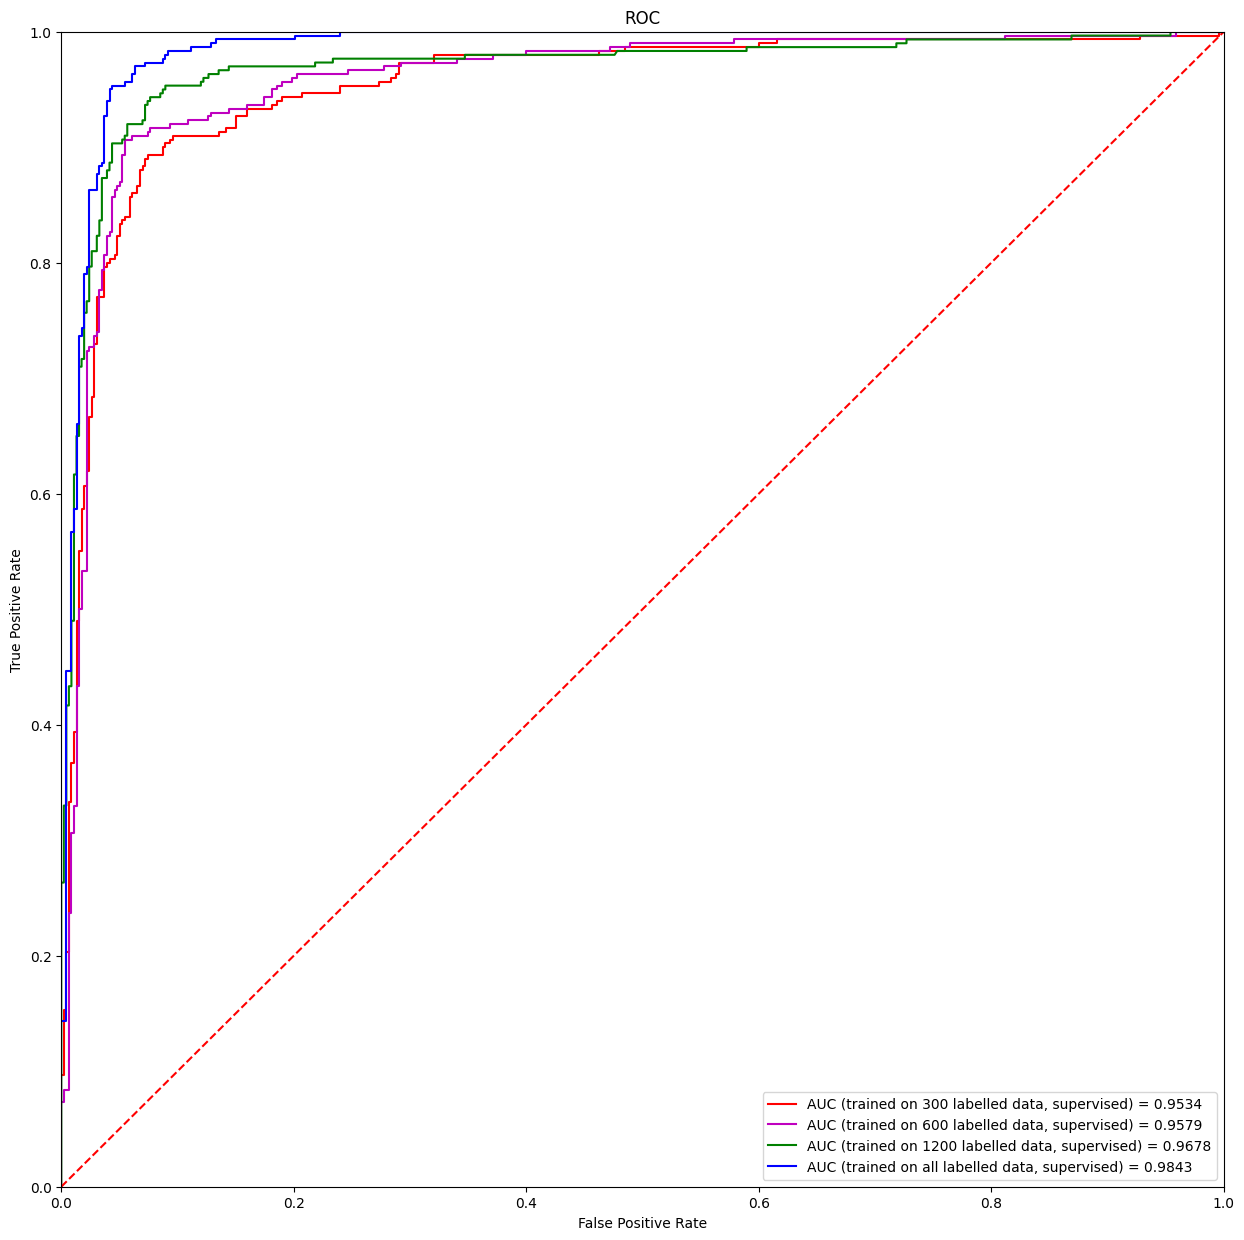

In [16]:
plt.figure(figsize=(15, 15))
plt.title('ROC')
plt.plot(fpr_supervised_300, tpr_supervised_300, 'r', label = 'AUC (trained on 300 labelled data, supervised) = %0.4f' % auc_score_300)
plt.plot(fpr_supervised_600, tpr_supervised_600, 'm', label = 'AUC (trained on 600 labelled data, supervised) = %0.4f' % auc_score_600)
plt.plot(fpr_supervised_1200, tpr_supervised_1200, 'g', label = 'AUC (trained on 1200 labelled data, supervised) = %0.4f' % auc_score_1200)
plt.plot(fpr_supervised_all, tpr_supervised_all, 'b', label = 'AUC (trained on all labelled data, supervised) = %0.4f' % auc_score_all)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("auc_supervised.png")
plt.show()

### ViT Base backbone pretrained with Simsiam 

In [17]:
state = torch.load("/kaggle/input/deeplense-git/simsiam-vit-base-ckpt.pth")

/tmp/ipykernel_24/3064819931.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("/kaggle/input/deeplense-git/simsiam-vit-base-ckpt.pth")


### ViT Base pretrained backbone finetuned on 300 labelled datapoints

In [18]:
set_seed(12)
train_loader, val_loader, test_loader = get_datasets(300)
ft_network = Classifier(mode = "finetune", backbone = copy.deepcopy(state["student"].backbone))
optimizer = torch.optim.Adam(ft_network.parameters(), lr=1e-4, weight_decay=0.0)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-8, T_max=num_epochs)
ft_network, ft_network_best_loss = train(ft_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

torch.save(ft_network, "/kaggle/working/finetuned_300_ckpt.pth")
fpr_simsiam_finetuned_300, tpr_simsiam_finetuned_300, auc_score_simsiam_finetuned_300 = compute_auc(ft_network, test_loader)

[1/100] Train Loss: 4.8500, Val Loss: 0.6372, Val Accuracy: 57.58%

[2/100] Train Loss: 2.1720, Val Loss: 1.0354, Val Accuracy: 60.37%

[3/100] Train Loss: 1.1123, Val Loss: 1.6390, Val Accuracy: 55.48%

[4/100] Train Loss: 0.9966, Val Loss: 0.5728, Val Accuracy: 60.37%

[5/100] Train Loss: 0.9373, Val Loss: 0.7869, Val Accuracy: 60.37%

[6/100] Train Loss: 0.8624, Val Loss: 0.6008, Val Accuracy: 59.91%

[7/100] Train Loss: 0.7062, Val Loss: 0.6656, Val Accuracy: 57.58%

[8/100] Train Loss: 0.5643, Val Loss: 0.5417, Val Accuracy: 63.40%

[9/100] Train Loss: 0.5389, Val Loss: 0.4788, Val Accuracy: 84.62%

[10/100] Train Loss: 0.6397, Val Loss: 0.6908, Val Accuracy: 71.10%

[11/100] Train Loss: 0.7475, Val Loss: 0.6088, Val Accuracy: 56.88%

[12/100] Train Loss: 0.6338, Val Loss: 0.5693, Val Accuracy: 63.87%

[13/100] Train Loss: 0.5840, Val Loss: 0.4867, Val Accuracy: 87.41%

[14/100] Train Loss: 0.5520, Val Loss: 0.4308, Val Accuracy: 82.98%

[15/100] Train Loss: 0.4952, Val Loss: 0.38

In [19]:
_, _, acc_simsiam_finetuned_300, auc_simsiam_finetuned_300 = test_(ft_network, val_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       231        |          28         |
| true nonlenses |        14        |         156         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 90.2098% |
|    loss   |  0.0541  |
| auc score |  0.9453  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9429  | 0.8919 |  0.9167 |   259   |
|   nonlenses    |   0.8478  | 0.9176 |  0.8814 |   170   |
| macro averaged |   0.8953  | 0.9048 |  0.8990 |         |
+----------------+-----------+--------+---------+---------+


In [20]:
_, _, acc_simsiam_finetuned_300, auc_simsiam_finetuned_300 = test_(ft_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       411        |          47         |
| true nonlenses |        26        |         274         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 90.3694% |
|    loss   |  0.0394  |
| auc score |  0.9539  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9405  | 0.8974 |  0.9184 |   458   |
|   nonlenses    |   0.8536  | 0.9133 |  0.8824 |   300   |
| macro averaged |   0.8970  | 0.9054 |  0.9004 |         |
+----------------+-----------+--------+---------+---------+


### ViT Base pretrained backbone finetuned on 600 labelled datapoints

In [21]:
set_seed(12)
train_loader, val_loader, test_loader = get_datasets(600)
ft_network = Classifier(mode = "finetune", backbone = copy.deepcopy(state["student"].backbone))
optimizer = torch.optim.Adam(ft_network.parameters(), lr=1e-4, weight_decay=1e-3)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-8, T_max=num_epochs)
ft_network, ft_network_best_loss = train(ft_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

torch.save(ft_network, "/kaggle/working/finetuned_600_ckpt.pth")
fpr_simsiam_finetuned_600, tpr_simsiam_finetuned_600, auc_score_simsiam_finetuned_600 = compute_auc(ft_network, test_loader)

[1/100] Train Loss: 2.8730, Val Loss: 0.8440, Val Accuracy: 48.72%

[2/100] Train Loss: 0.9613, Val Loss: 0.6868, Val Accuracy: 60.37%

[3/100] Train Loss: 0.6803, Val Loss: 0.5541, Val Accuracy: 60.37%

[4/100] Train Loss: 0.5973, Val Loss: 0.5449, Val Accuracy: 67.37%

[5/100] Train Loss: 0.5336, Val Loss: 0.4366, Val Accuracy: 74.59%

[6/100] Train Loss: 0.4259, Val Loss: 0.3316, Val Accuracy: 88.11%

[7/100] Train Loss: 0.3361, Val Loss: 0.2975, Val Accuracy: 86.95%

[8/100] Train Loss: 0.2742, Val Loss: 0.3460, Val Accuracy: 86.25%

[9/100] Train Loss: 0.3357, Val Loss: 0.3536, Val Accuracy: 84.38%

[10/100] Train Loss: 0.2871, Val Loss: 0.3611, Val Accuracy: 89.28%

[11/100] Train Loss: 0.2930, Val Loss: 0.3599, Val Accuracy: 85.31%

[12/100] Train Loss: 0.3726, Val Loss: 0.3265, Val Accuracy: 87.18%

[13/100] Train Loss: 0.3836, Val Loss: 0.4286, Val Accuracy: 86.95%

[14/100] Train Loss: 0.3228, Val Loss: 0.3982, Val Accuracy: 85.08%

[15/100] Train Loss: 0.2460, Val Loss: 0.28

In [22]:
_, _, acc_simsiam_finetuned_600, auc_simsiam_finetuned_600 = test_(ft_network, val_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       245        |          14         |
| true nonlenses |        19        |         151         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 92.3077% |
|    loss   |  0.2033  |
| auc score |  0.9548  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9280  | 0.9459 |  0.9369 |   259   |
|   nonlenses    |   0.9152  | 0.8882 |  0.9015 |   170   |
| macro averaged |   0.9216  | 0.9171 |  0.9192 |         |
+----------------+-----------+--------+---------+---------+


In [23]:
_, _, acc_simsiam_finetuned_600, auc_simsiam_finetuned_600 = test_(ft_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       433        |          25         |
| true nonlenses |        35        |         265         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 92.0844% |
|    loss   |  0.0879  |
| auc score |  0.9589  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9252  | 0.9454 |  0.9352 |   458   |
|   nonlenses    |   0.9138  | 0.8833 |  0.8983 |   300   |
| macro averaged |   0.9195  | 0.9144 |  0.9168 |         |
+----------------+-----------+--------+---------+---------+


### ViT Base pretrained backbone finetuned on 1200 labelled datapoints

In [24]:
set_seed(12)
train_loader, val_loader, test_loader = get_datasets(1200)
ft_network = Classifier(mode = "finetune", backbone = copy.deepcopy(state["student"].backbone))
optimizer = torch.optim.Adam(ft_network.parameters(), lr=1e-4, weight_decay=1e-8)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-8, T_max=num_epochs)
ft_network, ft_network_best_loss = train(ft_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

torch.save(ft_network, "/kaggle/working/finetuned_1200_ckpt.pth")
fpr_simsiam_finetuned_1200, tpr_simsiam_finetuned_1200, auc_score_simsiam_finetuned_1200 = compute_auc(ft_network, test_loader)

[1/100] Train Loss: 1.9671, Val Loss: 0.8267, Val Accuracy: 60.37%

[2/100] Train Loss: 0.6800, Val Loss: 0.6833, Val Accuracy: 51.52%

[3/100] Train Loss: 0.5566, Val Loss: 0.4210, Val Accuracy: 85.31%

[4/100] Train Loss: 0.3873, Val Loss: 0.3048, Val Accuracy: 88.81%

[5/100] Train Loss: 0.2952, Val Loss: 0.3037, Val Accuracy: 87.41%

[6/100] Train Loss: 0.2913, Val Loss: 0.3115, Val Accuracy: 87.88%

[7/100] Train Loss: 0.2865, Val Loss: 0.2899, Val Accuracy: 88.34%

[8/100] Train Loss: 0.2331, Val Loss: 0.2681, Val Accuracy: 89.04%

[9/100] Train Loss: 0.2282, Val Loss: 0.2963, Val Accuracy: 87.88%

[10/100] Train Loss: 0.2230, Val Loss: 0.2573, Val Accuracy: 90.21%

[11/100] Train Loss: 0.2121, Val Loss: 0.2685, Val Accuracy: 89.04%

[12/100] Train Loss: 0.2080, Val Loss: 0.2603, Val Accuracy: 89.74%

[13/100] Train Loss: 0.1894, Val Loss: 0.2698, Val Accuracy: 89.98%

[14/100] Train Loss: 0.1727, Val Loss: 0.2768, Val Accuracy: 88.81%

[15/100] Train Loss: 0.1689, Val Loss: 0.28

In [25]:
_, _, acc_simsiam_finetuned_1200, auc_simsiam_finetuned_1200 = test_(ft_network, val_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       248        |          11         |
| true nonlenses |        15        |         155         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 93.9394% |
|    loss   |  0.1357  |
| auc score |  0.9720  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9430  | 0.9575 |  0.9502 |   259   |
|   nonlenses    |   0.9337  | 0.9118 |  0.9226 |   170   |
| macro averaged |   0.9384  | 0.9346 |  0.9364 |         |
+----------------+-----------+--------+---------+---------+


In [26]:
_, _, acc_simsiam_finetuned_1200, auc_simsiam_finetuned_1200 = test_(ft_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       432        |          26         |
| true nonlenses |        23        |         277         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 93.5356% |
|    loss   |  0.0509  |
| auc score |  0.9817  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9495  | 0.9432 |  0.9463 |   458   |
|   nonlenses    |   0.9142  | 0.9233 |  0.9187 |   300   |
| macro averaged |   0.9318  | 0.9333 |  0.9325 |         |
+----------------+-----------+--------+---------+---------+


### ViT Base pretrained backbone finetuned on all datapoints

In [27]:
set_seed(12)
train_loader, val_loader, test_loader = get_datasets(None)
ft_network = Classifier(mode = "finetune", backbone = copy.deepcopy(state["student"].backbone))
optimizer = torch.optim.Adam(ft_network.parameters(), lr=1e-4, weight_decay=1e-8)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-8, T_max=num_epochs)
ft_network, ft_network_best_loss = train(ft_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

torch.save(ft_network, "/kaggle/working/finetuned_all_ckpt.pth")
fpr_simsiam_finetuned_all, tpr_simsiam_finetuned_all, auc_score_simsiam_finetuned_all = compute_auc(ft_network, test_loader)

[1/100] Train Loss: 1.0858, Val Loss: 0.5213, Val Accuracy: 82.75%

[2/100] Train Loss: 0.6539, Val Loss: 0.4660, Val Accuracy: 80.19%

[3/100] Train Loss: 0.3919, Val Loss: 0.4164, Val Accuracy: 82.05%

[4/100] Train Loss: 0.3381, Val Loss: 0.2746, Val Accuracy: 89.98%

[5/100] Train Loss: 0.2789, Val Loss: 0.2708, Val Accuracy: 89.51%

[6/100] Train Loss: 0.2649, Val Loss: 0.2563, Val Accuracy: 89.74%

[7/100] Train Loss: 0.2595, Val Loss: 0.2788, Val Accuracy: 89.98%

[8/100] Train Loss: 0.2498, Val Loss: 0.2669, Val Accuracy: 90.44%

[9/100] Train Loss: 0.2489, Val Loss: 0.2935, Val Accuracy: 89.74%

[10/100] Train Loss: 0.2337, Val Loss: 0.2439, Val Accuracy: 90.21%

[11/100] Train Loss: 0.2139, Val Loss: 0.2665, Val Accuracy: 89.51%

[12/100] Train Loss: 0.2115, Val Loss: 0.2335, Val Accuracy: 91.84%

[13/100] Train Loss: 0.2048, Val Loss: 0.2245, Val Accuracy: 90.44%

[14/100] Train Loss: 0.2007, Val Loss: 0.2202, Val Accuracy: 91.61%

[15/100] Train Loss: 0.1781, Val Loss: 0.25

In [28]:
_, _, acc_simsiam_finetuned_all, auc_simsiam_finetuned_all = test_(ft_network, val_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       248        |          11         |
| true nonlenses |        11        |         159         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 94.8718% |
|    loss   |  0.1147  |
| auc score |  0.9819  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9575  | 0.9575 |  0.9575 |   259   |
|   nonlenses    |   0.9353  | 0.9353 |  0.9353 |   170   |
| macro averaged |   0.9464  | 0.9464 |  0.9464 |         |
+----------------+-----------+--------+---------+---------+


In [29]:
_, _, acc_simsiam_finetuned_all, auc_simsiam_finetuned_all = test_(ft_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       437        |          21         |
| true nonlenses |        18        |         282         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 94.8549% |
|    loss   |  0.0385  |
| auc score |  0.9832  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9604  | 0.9541 |  0.9573 |   458   |
|   nonlenses    |   0.9307  | 0.9400 |  0.9353 |   300   |
| macro averaged |   0.9456  | 0.9471 |  0.9463 |         |
+----------------+-----------+--------+---------+---------+


### ROC Curves for the SSL model finetuning are plotted below

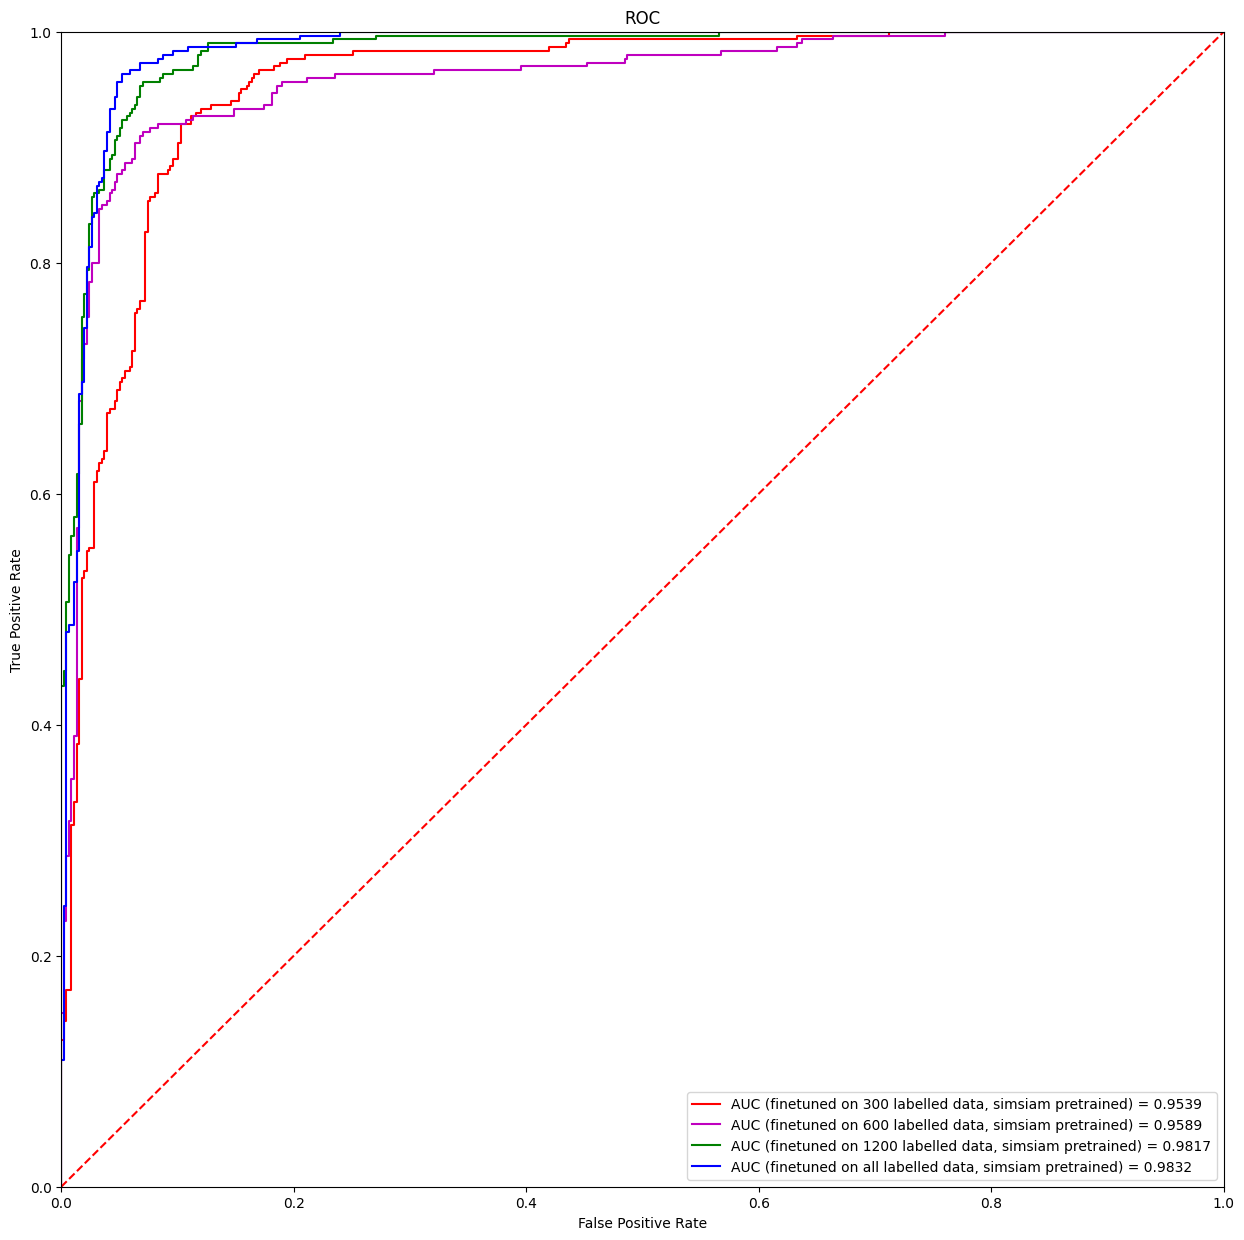

In [30]:
plt.figure(figsize=(15, 15))
plt.title('ROC')
plt.plot(fpr_simsiam_finetuned_300, tpr_simsiam_finetuned_300, 'r', label = 'AUC (finetuned on 300 labelled data, simsiam pretrained) = %0.4f' % auc_simsiam_finetuned_300)
plt.plot(fpr_simsiam_finetuned_600, tpr_simsiam_finetuned_600, 'm', label = 'AUC (finetuned on 600 labelled data, simsiam pretrained) = %0.4f' % auc_simsiam_finetuned_600)
plt.plot(fpr_simsiam_finetuned_1200, tpr_simsiam_finetuned_1200, 'g', label = 'AUC (finetuned on 1200 labelled data, simsiam pretrained) = %0.4f' % auc_simsiam_finetuned_1200)
plt.plot(fpr_simsiam_finetuned_all, tpr_simsiam_finetuned_all, 'b', label = 'AUC (finetuned on all labelled data, simsiam pretrained) = %0.4f' % auc_simsiam_finetuned_all)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("auc_ssl_simsiam.png")
plt.show()

### ROC Curves for the SSL and supervised models are plotted below

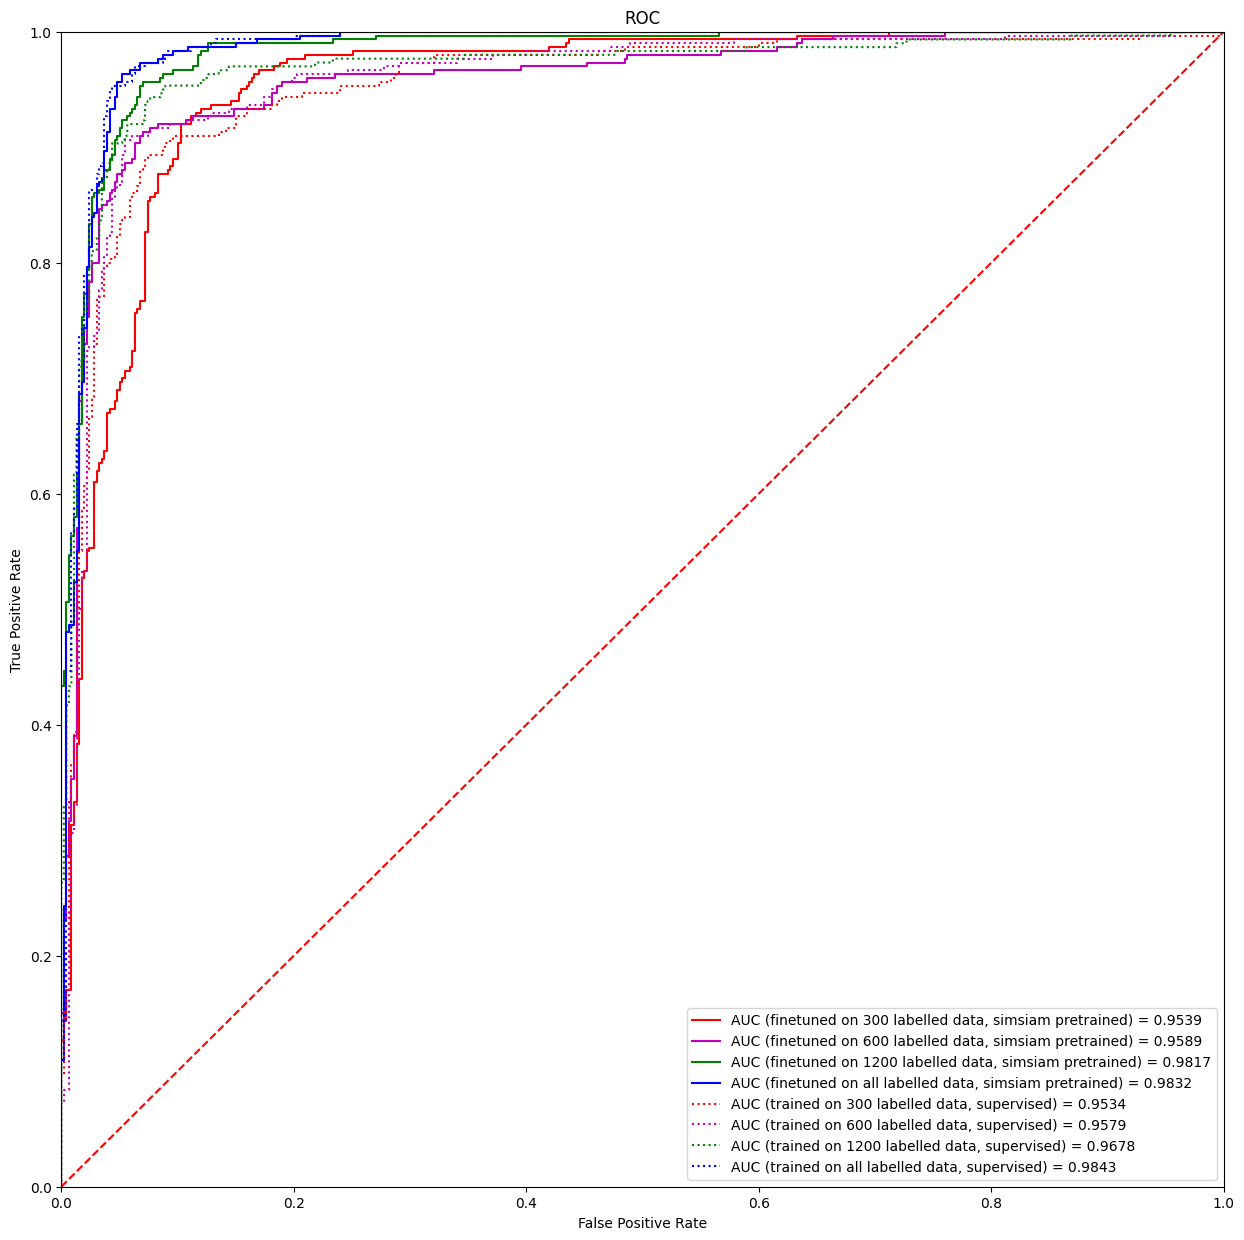

In [31]:
plt.figure(figsize=(15, 15))
plt.title('ROC')
plt.plot(fpr_simsiam_finetuned_300, tpr_simsiam_finetuned_300, 'r', label = 'AUC (finetuned on 300 labelled data, simsiam pretrained) = %0.4f' % auc_simsiam_finetuned_300)
plt.plot(fpr_simsiam_finetuned_600, tpr_simsiam_finetuned_600, 'm', label = 'AUC (finetuned on 600 labelled data, simsiam pretrained) = %0.4f' % auc_simsiam_finetuned_600)
plt.plot(fpr_simsiam_finetuned_1200, tpr_simsiam_finetuned_1200, 'g', label = 'AUC (finetuned on 1200 labelled data, simsiam pretrained) = %0.4f' % auc_simsiam_finetuned_1200)
plt.plot(fpr_simsiam_finetuned_all, tpr_simsiam_finetuned_all, 'b', label = 'AUC (finetuned on all labelled data, simsiam pretrained) = %0.4f' % auc_simsiam_finetuned_all)

plt.plot(fpr_supervised_300, tpr_supervised_300, 'r:', label = 'AUC (trained on 300 labelled data, supervised) = %0.4f' % auc_score_300)
plt.plot(fpr_supervised_600, tpr_supervised_600, 'm:', label = 'AUC (trained on 600 labelled data, supervised) = %0.4f' % auc_score_600)
plt.plot(fpr_supervised_1200, tpr_supervised_1200, 'g:', label = 'AUC (trained on 1200 labelled data, supervised) = %0.4f' % auc_score_1200)
plt.plot(fpr_supervised_all, tpr_supervised_all, 'b:', label = 'AUC (trained on all labelled data, supervised) = %0.4f' % auc_score_all)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("auc_supervised_ssl_simsiam.png")
plt.show()